In [168]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")

seed = 42
torch.manual_seed(seed)

In [142]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [143]:
X_train = train_dataset.train_data.view(-1, 28*28).float()/255.00
y_train = train_dataset.train_labels
X_test = test_dataset.test_data.view(-1, 28*28).float()/255.00
y_test = test_dataset.test_labels
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [144]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index].T, y_train[shuffle_index]
X_test, y_test = X_test.T, y_test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([784, 60000]),
 torch.Size([60000]),
 torch.Size([784, 10000]),
 torch.Size([10000]))

In [145]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [152]:
model = MLP(28*28, 30, 20, 10)

In [153]:
out_layer = model.fc3.weight.data.cpu().numpy()
out_layer.shape

(10, 20)

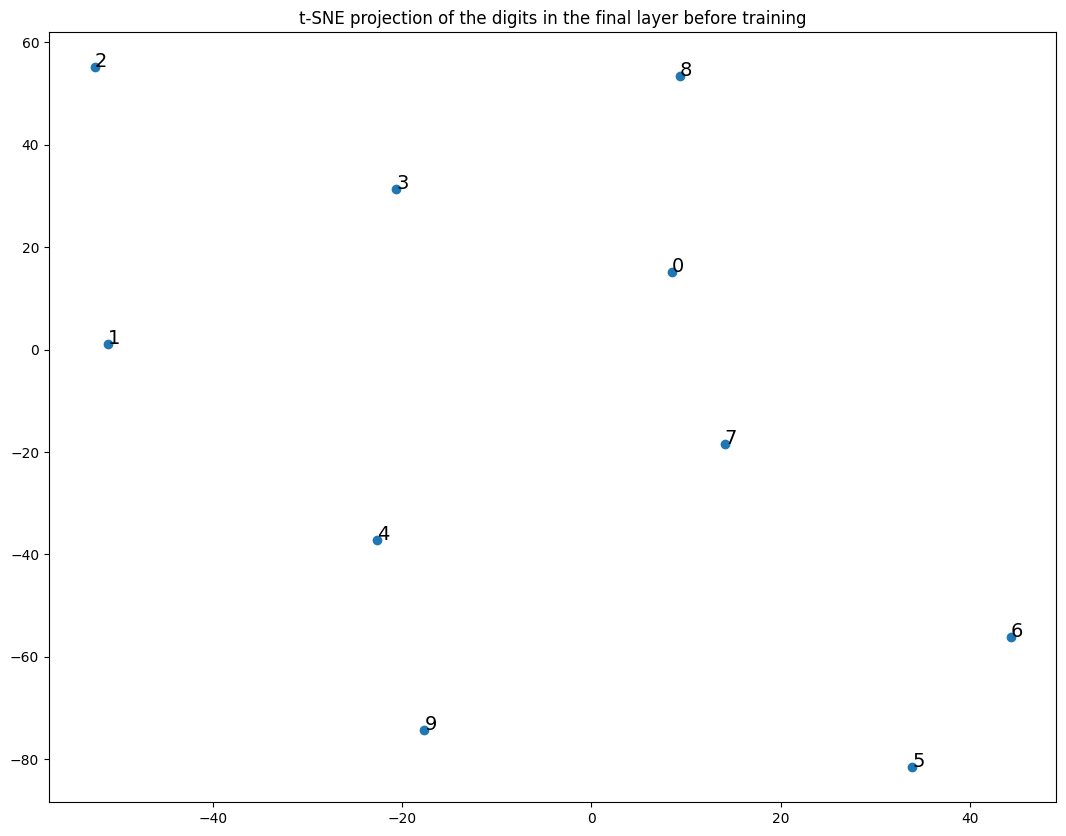

In [154]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_reduced = tsne.fit_transform(out_layer)

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i in range(10):
    plt.annotate(str(i), xy=(X_reduced[i, 0], X_reduced[i, 1]), fontsize=14)
plt.title('t-SNE projection of the digits in the final layer before training')
plt.show()


In [155]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
batch_size = 64

In [156]:
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X = X_train[:, i:i+batch_size]
        y = y_train[i:i+batch_size]
        outputs = model(X.T)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(X_train), loss.item()))

Epoch [1/100], Step [769/784], Loss: 1.3805
Epoch [11/100], Step [769/784], Loss: 0.3044
Epoch [21/100], Step [769/784], Loss: 0.0061
Epoch [31/100], Step [769/784], Loss: 0.0026
Epoch [41/100], Step [769/784], Loss: 0.0015
Epoch [51/100], Step [769/784], Loss: 0.0010
Epoch [61/100], Step [769/784], Loss: 0.0007
Epoch [71/100], Step [769/784], Loss: 0.0005
Epoch [81/100], Step [769/784], Loss: 0.0004
Epoch [91/100], Step [769/784], Loss: 0.0003


In [157]:
preds = model(X_test.T)
_, predicted = torch.max(preds, 1)

In [163]:
accuracy = accuracy_score(y_test, predicted)
f1_score = f1_score(y_test, predicted, average='weighted')
print('Accuracy using MLP: {:.2f}%'.format(accuracy*100))
print('F1 Score using MLP: {:.2f}'.format(f1_score))

Accuracy using MLP: 88.07%
F1 Score using MLP: 0.88


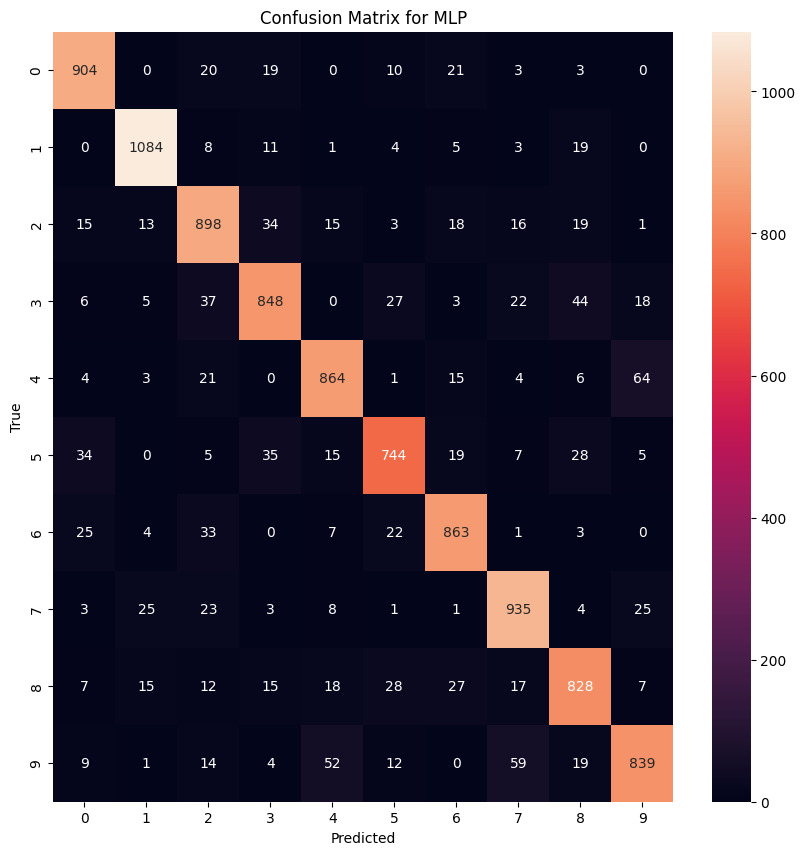

In [164]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

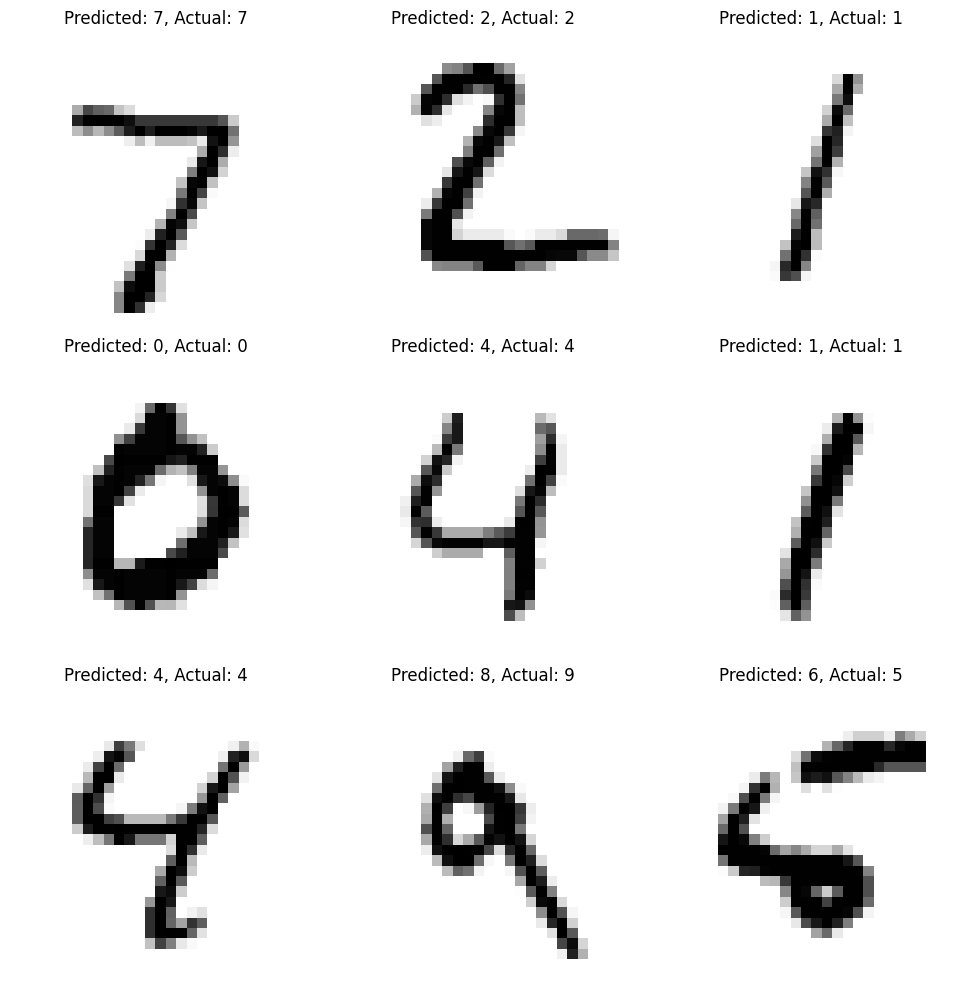

In [165]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[:, i].reshape(28, 28), cmap='binary')
    ax.set_title('Predicted: {}, Actual: {}'.format(predicted[i], y_test[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

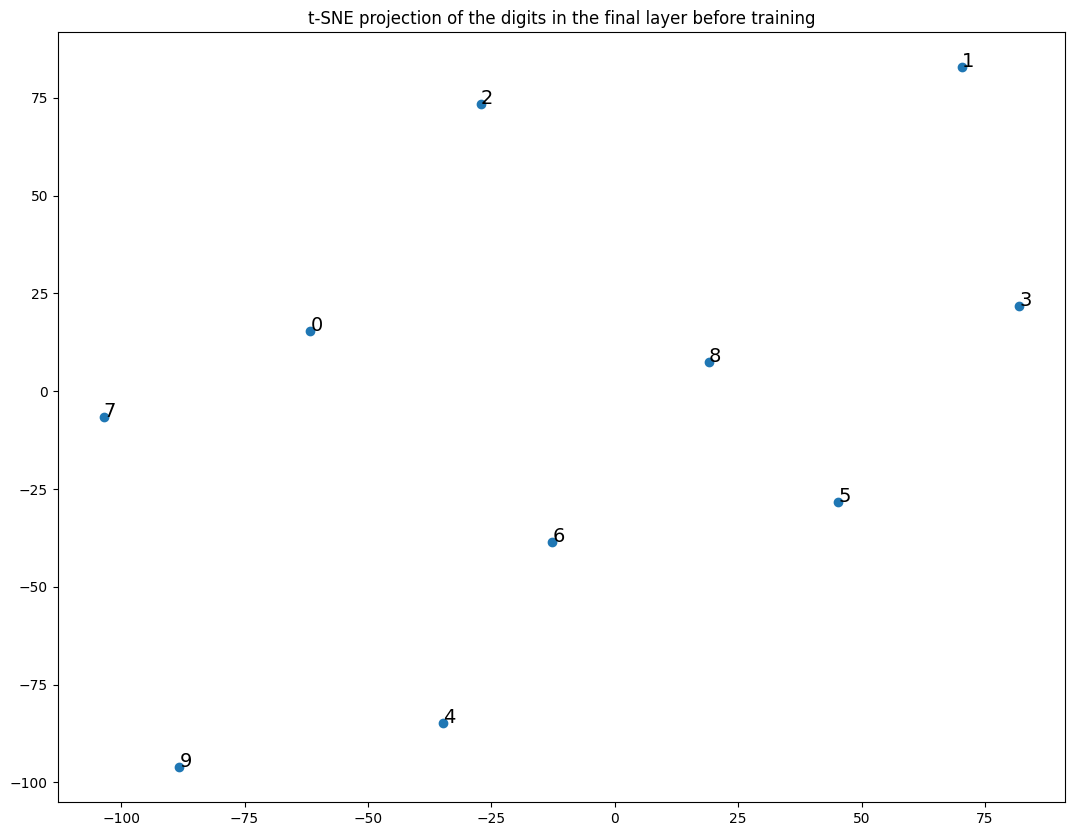

In [166]:
out_layer = model.fc3.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_reduced = tsne.fit_transform(out_layer)

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i in range(10):
    plt.annotate(str(i), xy=(X_reduced[i, 0], X_reduced[i, 1]), fontsize=14)
plt.title('t-SNE projection of the digits in the final layer before training')
plt.show()

Here we can see that before training our digits were spread across randomly, but after training we can see that digits are closer to the digits which they are confused with (eg 4, 7, 9).

In [167]:
X_train = X_train.numpy()
X_test = X_test.numpy()
y_train = y_train.numpy()
y_test = y_test.numpy()

In [169]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train.T, y_train)

LogisticRegression(random_state=42)

In [170]:
preds = log_reg.predict(X_test.T)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, preds)*100))
print('F1 Score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

Accuracy: 92.56%
F1 Score: 0.93


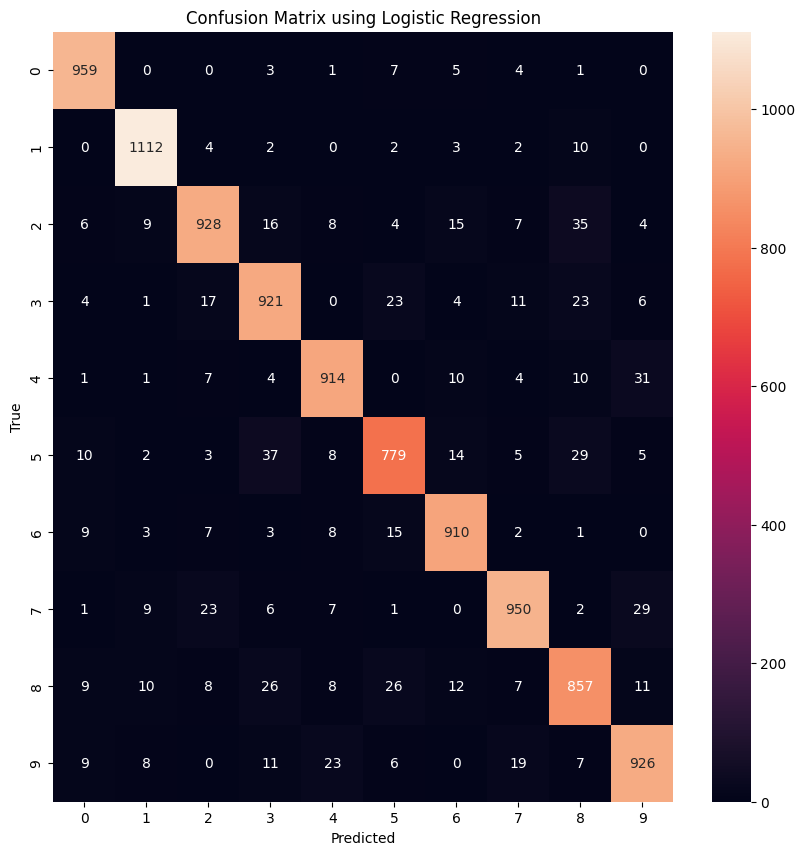

In [171]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix using Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [172]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.T, y_train)

RandomForestClassifier(random_state=42)

In [173]:
preds = rf.predict(X_test.T)
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, preds)*100))
print('F1 Score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

Accuracy: 96.91%
F1 Score: 0.97


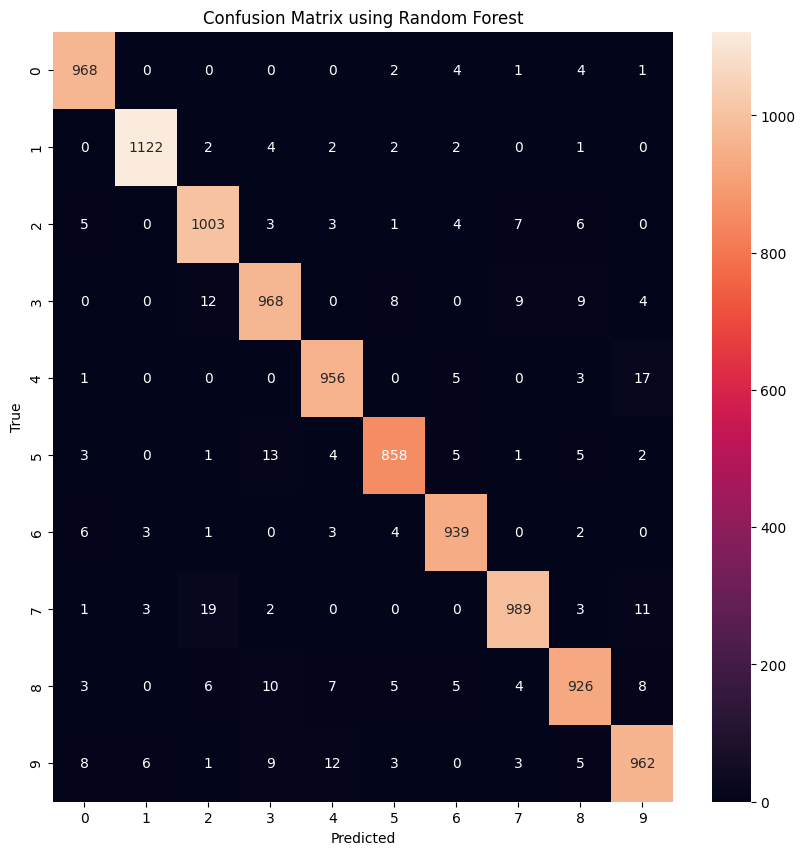

In [174]:
cn = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cn, annot=True, fmt="d")
plt.title('Confusion Matrix using Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Here we can see that accross all models the digit 9 is often confused with digits 4 and 7, this may be due to them actually looking very similar which the model cannot judge correctly.

In [175]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [176]:
X_train = train_dataset.train_data.view(-1, 28*28).float()/255.00
y_train = train_dataset.train_labels
X_test = test_dataset.test_data.view(-1, 28*28).float()/255.00
y_test = test_dataset.test_labels
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [177]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index].T, y_train[shuffle_index]
X_test, y_test = X_test.T, y_test

In [178]:
preds = model(X_test.T)
_, predicted = torch.max(preds, 1)

In [179]:
print('Accuracy using MLP: {:.2f}%'.format(accuracy_score(y_test, predicted)*100))
print('F1 Score using MLP: {:.2f}'.format(f1_score(y_test, predicted, average='weighted')))

Accuracy using MLP: 1.54%
F1 Score using MLP: 0.01


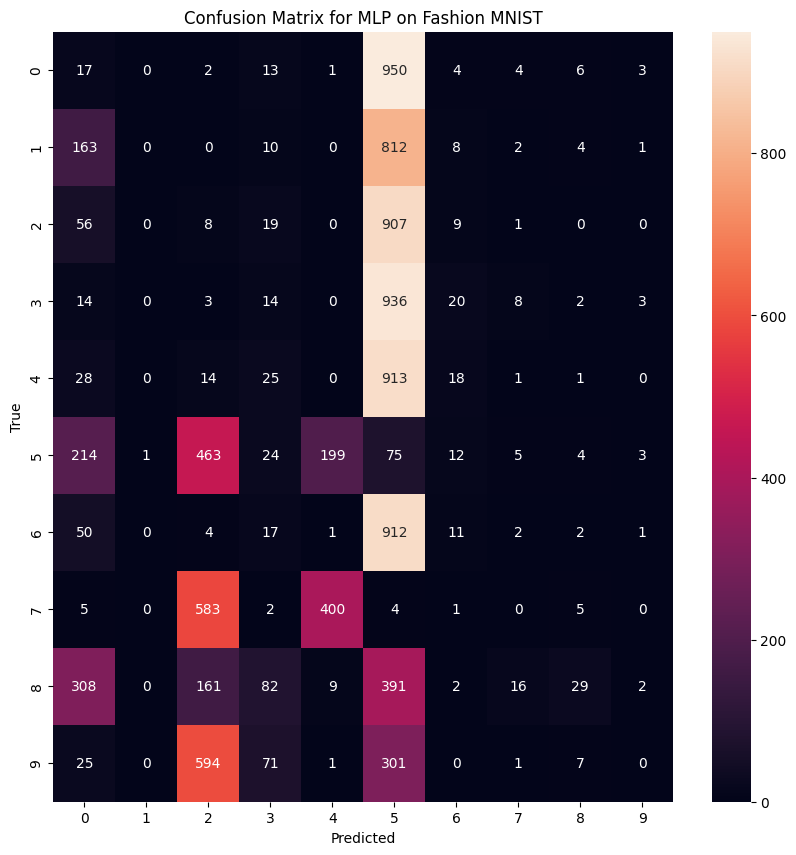

In [180]:
cn = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cn, annot=True, fmt="d")
plt.title('Confusion Matrix for MLP on Fashion MNIST')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

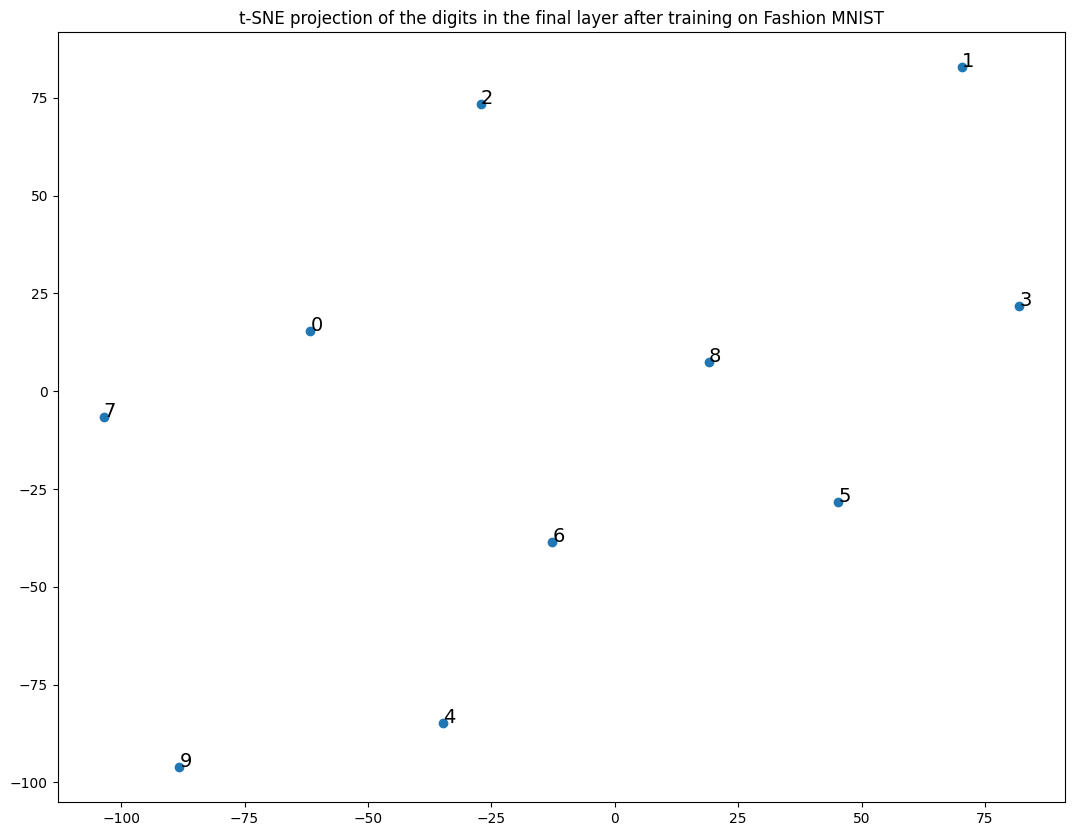

In [181]:
out_layer = model.fc3.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_reduced = tsne.fit_transform(out_layer)

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for i in range(10):
    plt.annotate(str(i), xy=(X_reduced[i, 0], X_reduced[i, 1]), fontsize=14)
plt.title('t-SNE projection of the digits in the final layer after training on Fashion MNIST')
plt.show()